This notebook simulates a population of binary stars, then maps to the data which would apprear in a typical Robo-AO cataloug through a series of transformations.

Each bolded markdown label cooresponds to the steps outlined in Fig 1 of this paper: https://arxiv.org/pdf/1911.12337.pdf

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import numpy as np
import pandas as pd
import random

# Population

Simulating the physical properties of systems:

In [2]:
# SEPARATIONS (AU)

N = 2000
gaussian_center = 25
gaussian_width = 30
gaussian = np.random.normal(loc=gaussian_center, scale=gaussian_width, size=N)
sep_physical = gaussian[gaussian>0]                              
n = len(sep_physical)

# DISTANCES (PARSECS)
# Limiting to 100 pc around us, the distances should follow a power law with index 2, as n increases with r^2
dist_physical  = np.random.power(2, size=n)*100               # in parsecs              

# MASS RATIOS
power_law_index = 1.2
mass_ratios = np.random.power(power_law_index, size=n)

# OVERAL MULTIPLICITY         # probably won't end up using this one...
multiplicity = 0.3   # 30%

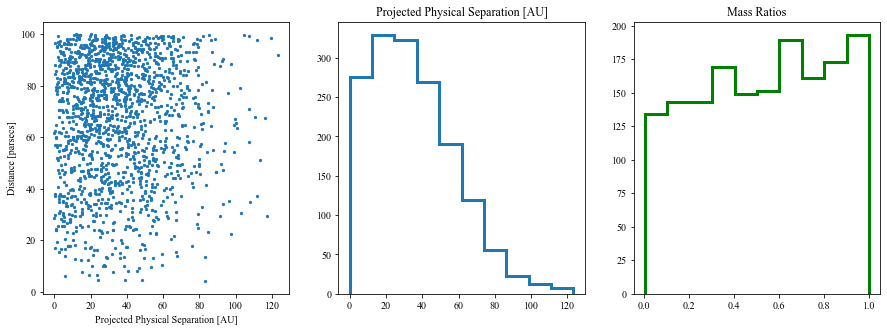

In [3]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(sep_physical, dist_physical, s=5)
plt.xlabel('Projected Physical Separation [AU]')
plt.ylabel('Distance [parsecs]')

plt.subplot(132)
plt.hist(sep_physical, bins=10, histtype='step', linewidth=3)
plt.title('Projected Physical Separation [AU]');

plt.subplot(133)
plt.title('Mass Ratios')
plt.hist(mass_ratios, histtype='step', color='g', linewidth=3);

# Observables

## Mapping

**Separations:**

$\text{parallax }["] =\frac{1}{\text{distance }[pc] }$

$\text{angular separation }["] = \big(\text{physical separation }[AU]\big)\ \  x\ \ \big(\text{parallax }["]\big)$


**Contrast Ratios:**

From section 4.4 of (Lamman et al), we have an emperical relationship between mass ratio ($R_m$) and Robo-AO contrast ratio ($R_c$), given by a 4th degree polynomial:

$R_c = 22.5 - 68.2R_m + 76.77R_m^2 -41.84R_m^3  +10.8R_m^4$

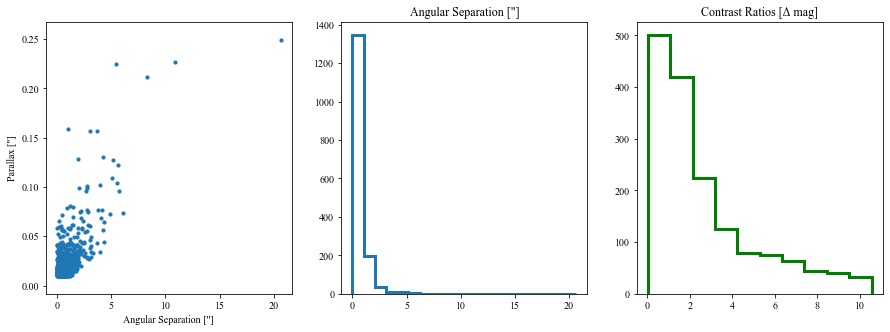

In [4]:
# SEPARATIONS
dist_parallax = 1 / dist_physical
sep_angular = sep_physical / dist_physical

fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(sep_angular, dist_parallax, s=10)
plt.xlabel('Angular Separation ["]')
plt.ylabel('Parallax ["]')

plt.subplot(132)
plt.hist(sep_angular, bins=20, histtype='step', linewidth=3)
plt.title('Angular Separation ["]');



# CONTRAST RATIOS
mr_to_cr = np.poly1d([ 22.49530266, -68.20328041,  76.76906887, -41.84387402, 10.80058044])
contrast_ratios = mr_to_cr(mass_ratios)

plt.subplot(133)
plt.title(u'Contrast Ratios [Δ mag]')
plt.hist(contrast_ratios, histtype='step', color='g', linewidth=3);

# Measurements

**MAPPING**

Robo-AO Errors for all angular separations $\approx 0.07"$

Gaia parallax errors $\approx 0.005$ (Max is $\sim 0.015$, but will ignore parallax errors for now)

Here I'll just use a rought estimate of typical Robo-AO contrast errors. I'll model it as mostly random but higher for systems at close separations.

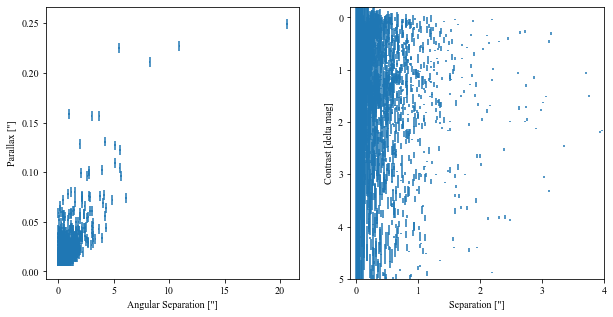

In [5]:
# Separations
sep_ang_e = 0.07
dist_parallax_e = 0.005

# Contrasts
cr_err = np.random.random_sample((len(contrast_ratios),))/10
cr_err = (cr_err/(sep_angular))*np.random.random()

fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.errorbar(sep_angular, dist_parallax, xerr=sep_ang_e, yerr=dist_parallax_e, ls='none')
plt.xlabel('Angular Separation ["]')
plt.ylabel('Parallax ["]');

plt.subplot(122)
plt.errorbar(sep_angular, contrast_ratios, yerr=cr_err, ls='none')
plt.ylim(5, -0.2); plt.xlim(-0.1, 4)
plt.xlabel('Separation ["]'); plt.ylabel('Contrast [delta mag]');

# Catalog

**MAPPING**
 
Robo-AO will generally only detect a companion if:

1. $(\text{angular separation})\  < 4.0"$   (Survey only looked within $4"$, 0.1" is )


2. $(\text{Robo-AO contrast})\  < 1.8\ \ln{(\text{angular separation ["])}} + 3.8$<br>
_This is a ROUGH model of a typical Robo-AO contrast curve, and should be improved in the future by creating a model based on the average contrast curve of each observation in the survey, or take into account individual contrast curves._

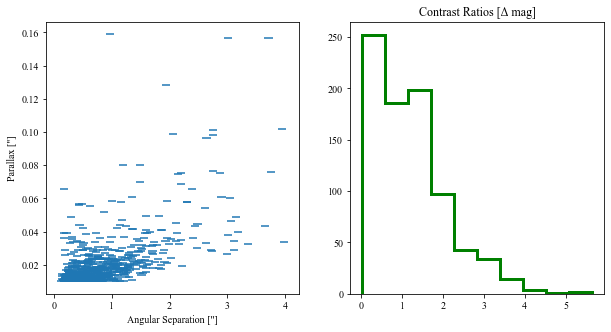

In [6]:
sep_ang_max = 4
def roboao_cc(s):
    return 1.8 * np.log(s) + 3.8

measurements = pd.DataFrame(np.transpose(np.array([sep_angular, [sep_ang_e]*len(sep_angular), 
                                                   contrast_ratios, cr_err, dist_parallax])), 
                            columns = ['asep', 'asep_err', 'cr', 'cr_err', 'parallax'])
catalog = measurements[(measurements['asep']<sep_ang_max) & 
                       (measurements['cr']<roboao_cc(measurements['asep']))]

fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.errorbar(catalog['asep'], catalog['parallax'], xerr=sep_ang_e, ls='none') #yerr=dist_parallax_e
plt.xlabel('Angular Separation ["]')
plt.ylabel('Parallax ["]')

plt.subplot(122)
plt.title(u'Contrast Ratios [Δ mag]')
plt.hist(catalog['cr'], histtype='step', color='g', linewidth=3);

## "Recreating" Fig 6 in the original survey paper
https://arxiv.org/pdf/2001.05988.pdf

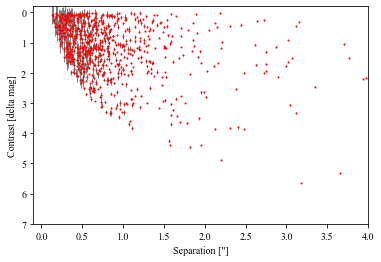

In [7]:
plt.errorbar(catalog['asep'], catalog['cr'], yerr=catalog['cr_err'], 
             marker='.', mec='r', ms=2, ls='none', linewidth=1, ecolor='grey')
plt.ylim(7, -0.2); plt.xlim(-0.1, 4)
plt.xlabel('Separation ["]'); plt.ylabel('Contrast [delta mag]');